In [0]:
import time
import pandas as pd
import numpy as np
import datetime
import itertools
from google.colab import drive
from collections import defaultdict
from scipy.special import softmax
import pickle
import matplotlib.pyplot as plt

In [2]:
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [0]:
######### load and process data #########
data = pd.read_csv('/content/gdrive/Shared drives/CS 238/time_series_60min_singleindex.csv')
data['utc_timestamp'] = pd.to_datetime(data['utc_timestamp'])

filter_col = ['utc_timestamp'] + [col for col in data if col.startswith('DE')]
data = data[filter_col]

data = data[data['utc_timestamp'] >= datetime.datetime(2015, 1, 1, tzinfo=datetime.timezone.utc)]
data = data[data['utc_timestamp'] < datetime.datetime(2019, 1, 1, tzinfo=datetime.timezone.utc)]
data = data.reset_index().drop(columns=['index'])

columns = ['utc_timestamp', 'DE_load_actual_entsoe_transparency', 'DE_solar_generation_actual', 'DE_wind_generation_actual']
data = data[columns]

data.rename(columns={'utc_timestamp': 'timestamp', 'DE_load_actual_entsoe_transparency': 'load', 'DE_solar_generation_actual': 'solar', 'DE_wind_generation_actual': 'wind'}, inplace=True)

n_buckets = {
    'time_of_day': 12,
    'time_of_year': 4,
    'load_scaled': 10,
    'solar_scaled': 5,
    'wind_scaled': 9,
}

def scale(col, n_buckets):
  return (col - col.min()) / (col.max() - col.min()) * (n_buckets - 1)

data['time_of_day'] = scale(data['timestamp'].apply(lambda timestamp: timestamp.to_pydatetime().hour), n_buckets['time_of_day'])
data['time_of_year'] = scale(data['timestamp'].apply(lambda timestamp: timestamp.to_pydatetime().month - 1 + (timestamp.to_pydatetime().day - 1) / 31.0), n_buckets['time_of_year'])
data['load_scaled'] = scale(data['load'], n_buckets['load_scaled'])
data['solar_scaled'] = scale(data['solar'], n_buckets['solar_scaled'])
data['wind_scaled'] = scale(data['wind'], n_buckets['wind_scaled'])

train_ = data[data['timestamp'] < datetime.datetime(2018, 1, 1, tzinfo=datetime.timezone.utc)] 
test = data[data['timestamp'] >= datetime.datetime(2018, 1, 1, tzinfo=datetime.timezone.utc)].reset_index().drop(columns=['index'])

In [0]:
######### define functions #########
def get_neighbor_weights(data_state):
  data_state = np.array(data_state)
  neighbors = list(itertools.product(*((np.floor(s), np.ceil(s)) for s in data_state)))
  weights = []
  for neighbor in neighbors:
    neighbor = np.array(neighbor)
    weights.append(np.linalg.norm(1 - np.abs(data_state - neighbor)))

  weights = np.array(weights)
  return neighbors, weights / weights.sum()


#gives you the valid actions from a given plant state
def get_valid_actions(plant_state):
  num_on = plant_state[0]
  num_off = n-sum(plant_state)
  return np.arange(-plant_state[0], num_off+1)


def get_Q_values(data_state, plant_state, valid_actions, neighbor_states, neighbor_weights):
  Q_a = np.zeros(len(valid_actions))
  for i, action in enumerate(valid_actions):
    for j, neighbor_state in enumerate(neighbor_states):
      Q_a[i] += neighbor_weights[j] * Q[(neighbor_state + plant_state, action)]

  return Q_a


def update_plant_state(plant_state, action):
  if action >= 0:
    return (plant_state[0] + plant_state[1],) + plant_state[2:] + (action,)
  else:
    return (plant_state[0] + plant_state[1] + action,) + plant_state[2:] + (0,)

def get_data_state(row):
  return (row['time_of_day'], row['time_of_year'], row['load_scaled'], row['solar_scaled'], row['wind_scaled'])

In [5]:
######### evaluate random policy #########
n = 16
n_random_runs = 5
reward_sum_random = 0.0

for _ in range(n_random_runs):
  plant_state = (0,0,0)

  for ind, row in test[:-1].iterrows():
    valid_actions = get_valid_actions(plant_state)
    action = np.random.choice(valid_actions)

    plant_state = update_plant_state(plant_state, action)
    next_row = test.loc[ind+1]
    diff = plant_state[0] * 5000.0 + next_row['solar'] + next_row['wind'] - next_row['load']

    reward = -5000.0 * plant_state[0]
    if diff < 0:
      reward += 10*diff
    reward_sum_random += reward

reward_sum_random /= n_random_runs
print('random policy reward sum: {:.1f}'.format(reward_sum_random))

random policy reward sum: -1676399914.0


In [6]:
######### evaluate reactive policy #########
reward_sum_reactive = 0.0
plant_state = (0,0,0)

for ind, row in test[:-1].iterrows():
  valid_actions = get_valid_actions(plant_state)
  diff = plant_state[0] * 5000.0 + row['solar'] + row['wind'] - row['load']

  if diff >= 0:
    n_plants_to_turn_off = np.floor(diff / 5000.0)
    action = -n_plants_to_turn_off if -n_plants_to_turn_off in valid_actions else np.min(valid_actions)
  else:
    n_plants_to_turn_on = np.ceil(-diff / 5000.0)
    action = n_plants_to_turn_on if n_plants_to_turn_on in valid_actions else np.max(valid_actions)

  plant_state = update_plant_state(plant_state, action)
  next_row = test.loc[ind+1]
  diff = plant_state[0] * 5000.0 + next_row['solar'] + next_row['wind'] - next_row['load']

  reward = -5000.0 * plant_state[0]
  if diff < 0:
    reward += 10*diff
  reward_sum_reactive += reward

print('reactive policy reward sum: {:.1f}'.format(reward_sum_reactive))

reactive policy reward sum: -543921590.0


In [10]:
######### load Q #########
reward_sums_optimal = []
for epoch in range(0, 526, 5):
  Q = pickle.load(open('/content/gdrive/Shared drives/CS 238/Q_2_hour_fixed.{}'.format(epoch), 'rb'))
  Q = defaultdict(lambda: -725000.0, Q)

  ######### extract and evaluate optimal policy #########
  optimal_policy = []
  reward_sum_optimal = 0.0
  plant_state = (0,0,0)
  

  for ind, row in test[:-1].iterrows():
    data_state = get_data_state(row)
    neighbor_states, neighbor_weights = get_neighbor_weights(data_state)
    valid_actions = get_valid_actions(plant_state)
    Q_a = get_Q_values(data_state, plant_state, valid_actions, neighbor_states, neighbor_weights)

    action = valid_actions[np.argmax(Q_a)]
    optimal_policy.append(action)

    plant_state = update_plant_state(plant_state, action)
    next_row = test.loc[ind+1]
    diff = plant_state[0] * 5000.0 + next_row['solar'] + next_row['wind'] - next_row['load']

    reward = -5000.0 * plant_state[0]
    if diff < 0:
      reward += 10*diff
    reward_sum_optimal += reward

  print('##################### {:02d} epochs of training #####################'.format(epoch))
  print('optimal policy reward sum: {:.1f}'.format(reward_sum_optimal))
  print('random  policy has {:.1f}% more negative reward than optimal policy'.format((reward_sum_random / reward_sum_optimal - 1) * 100))
  print('reactive  policy has {:.1f}% more negative reward than optimal policy'.format((reward_sum_reactive / reward_sum_optimal - 1) * 100))
  reward_sums_optimal.append(reward_sum_optimal)
  print()

##################### 00 epochs of training #####################
optimal policy reward sum: -3014050410.0
random  policy has -44.4% more negative reward than optimal policy
reactive  policy has -82.0% more negative reward than optimal policy

##################### 05 epochs of training #####################
optimal policy reward sum: -1699007350.0
random  policy has -1.3% more negative reward than optimal policy
reactive  policy has -68.0% more negative reward than optimal policy

##################### 10 epochs of training #####################
optimal policy reward sum: -1170380190.0
random  policy has 43.2% more negative reward than optimal policy
reactive  policy has -53.5% more negative reward than optimal policy

##################### 15 epochs of training #####################
optimal policy reward sum: -995773190.0
random  policy has 68.4% more negative reward than optimal policy
reactive  policy has -45.4% more negative reward than optimal policy

##################### 20 epo

In [0]:
reward_sums_optimal = np.array(reward_sums_optimal)
with open('/content/gdrive/Shared drives/CS 238/optimal_policy_reward_sums_0_525.npy', 'wb') as outfile:
  np.save(outfile, reward_sums_optimal)

Text(0.5, 0, 'Epoch')

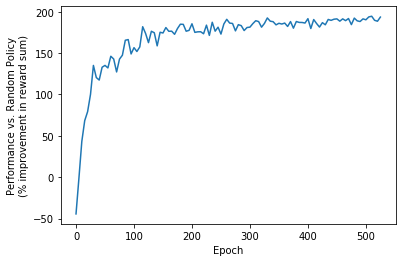

In [19]:
X = [epoch for epoch in range(0, 526, 5)]
Y = (reward_sum_random / reward_sums_optimal - 1) * 100
plt.plot(X,Y)
plt.ylabel("Performance vs. Random Policy\n(% improvement in reward sum)")
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

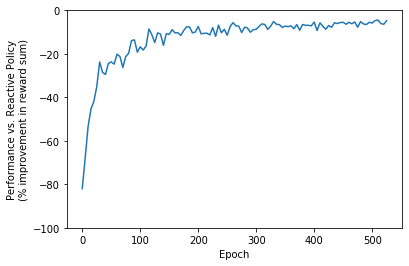

In [18]:
Y = (reward_sum_reactive / reward_sums_optimal - 1) * 100
plt.plot(X,Y)
plt.ylim(-100, 0)
plt.ylabel("Performance vs. Reactive Policy\n(% improvement in reward sum)")
plt.xlabel("Epoch")

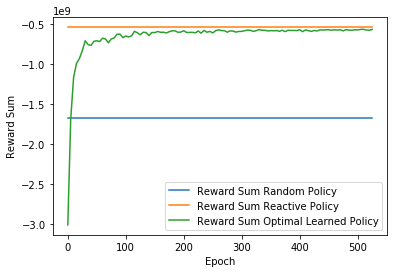

In [17]:
plt.plot('Epoch', 'Reward Sum Random Policy', data={'Epoch': X, 'Reward Sum Random Policy': [reward_sum_random] * len(X)})
plt.plot('Epoch', 'Reward Sum Reactive Policy', data={'Epoch': X, 'Reward Sum Reactive Policy': [reward_sum_reactive] * len(X)})
plt.plot('Epoch', 'Reward Sum Optimal Learned Policy', data={'Epoch': X, 'Reward Sum Optimal Learned Policy': reward_sums_optimal})
plt.xlabel('Epoch')
plt.ylabel('Reward Sum')
plt.legend()
plt.show()